<a href="https://colab.research.google.com/github/urlapovia03/university/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%9611_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D1%85_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%B2_%D1%81%D1%80%D0%B5%D0%B4%D0%B5_Google_Earth_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №11. Обработка больших пространственных данных в среде Google Earth Engine**

Перед выполнением заданий необходимо ознакомиться (вспомнить) и запустить последовательно следующий материал:

1. [**Geemap. Часть 1: Подготовка среды и базовые картографические инструменты**](https://colab.research.google.com/drive/1ZQsl0L6yt4YEZ40Pb97KnTFjYK5zslcE?usp=sharing)
2. [**Geemap. Часть 2: Геопространственный анализ и экспорт результатов**](https://colab.research.google.com/drive/19wOWQc80TiZSNy9foAc8qP5EqpbaBD62?usp=sharing)
3. [**Geemap. Часть 3: Расширенные средства визуализации и анализа данных**](https://colab.research.google.com/drive/1yN5f8gJQs6ZoAyZNfjNclRv0EB83qPGz?usp=sharing)

## **Устанавливаем необходимые зависимости и авторизуемся в Google Earth Engine (GEE)**

P.S.: Необходимо заранее создать в GEE проект и сделать его некоммерческим в настройках, см. первую часть теории.

In [1]:
!pip install -U "geemap[workshop]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.1/472.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3


## **Задание 1. Визуализация данных цифровой модели рельефа (ЦМР)**



Найдите набор данных ЦМР в [Каталоге данных Earth Engine](https://developers.google.com/earth-engine/datasets) и выполните обрезку растра по границам выбранной территории (например, вашей страны, региона или города - полигоны можно загрузить в OSM). Отобразите результат с использованием подходящей **цветовой палитры**. В качестве примера на карте ниже представлена ЦМР штата Колорадо.

![](https://i.imgur.com/OLeSt7n.png)

In [4]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='geeproject-482020')
m = geemap.Map()
dataset = ee.Image('IGN/RGE_ALTI/1M/2_0/FXX')
dem = dataset.select('MNT')
france = (
    ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    .filter(ee.Filter.eq('country_na', 'France'))
)
dem_clipped = dem.clip(france)
dem_vis = {
    'min': 0,
    'max': 1000,
    'palette': [
        '006600',
        '002200',
        'fff700',
        'ab7634',
        'c4d0ff',
        'ffffff'
    ]
}
m.addLayer(dem_clipped, dem_vis, 'RGE ALTI 1m (France)')
m.addLayer(france, {}, 'France boundary')
m.centerObject(france, 6)
m

Map(center=[46.51113080220531, 2.5775222884539257], controls=(WidgetControl(options=['position', 'transparent_…

## **Задание 2. Создание безоблачного композита на основе данных Sentinel-2 или Landsat**



Используйте данные [Sentinel-2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) или [Landsat-9](https://developers.google.com/earth-engine/datasets/catalog/landsat-9) для создания **безоблачного композитного изображения** за определённый год для выбранного вами региона. Отобразите полученное изображение на карте с применением соответствующей **комбинации спектральных каналов**. В качестве примера на карте ниже представлен безоблачный композит Sentinel-2 в синтезированных цветах (false-color) за 2021 год для штата Колорадо.

![](https://i.imgur.com/xkxpkS1.png)


In [16]:
# Инициализация Earth Engine
ee.Initialize(project='geeproject-482020')

# Границы штата Нью-Йорк (прямоугольник)
# Координаты: запад, юг, восток, север
region = ee.Geometry.Rectangle(
    [-79.8, 40.5, -71.8, 45.1]
)

# Коллекция Landsat-9 за лето 2022
dataset = (
    ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    .filterDate('2022-03-01', '2024-09-01')
    .filterBounds(region)
)

# Упрощённая маска облаков
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 3).eq(0)
    return image.updateMask(cloud)

# Масштабирование отражательной способности
def apply_scale_factors(image):
    optical = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    return image.addBands(optical, None, True)

# Подготовка коллекции
dataset = dataset.map(mask_clouds).map(apply_scale_factors)

# Медианный безоблачный композит
composite = dataset.median().clip(region)

# Визуализация (естественные цвета)
vis = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.03,
    'max': 0.6,
    'gamma': 2.7
}

# Карта
m = geemap.Map(center=[42.8, -75.0], zoom=6)
m.addLayer(composite, vis, 'Landsat-9 Composite 2022 (New York)')
m.addLayer(region, {}, 'New York (rectangle)')
m


Map(center=[42.8, -75.0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

## **Задание 3. Визуализация аэрофотоснимков NAIP**


Используйте данные [NAIP](https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ) (Национальная программа аэрофотосъёмки сельскохозяйственных угодий США) для создания безоблачного изображения выбранного вами округа США. В качестве примера на карте ниже представлен безоблачный композит NAIP в **натуральных цветах** (true-color) для округа Нокс, штат Теннесси. Обратите внимание, что в разных штатах могут существовать округа с одинаковыми названиями — убедитесь, что выбран корректный округ для указанного штата.

![](https://i.imgur.com/iZSGqGS.png)

In [18]:
# Границы округов США
counties = ee.FeatureCollection('TIGER/2018/Counties')

#
county = counties.filter(
    ee.Filter.And(
        ee.Filter.eq('NAME', 'Santa Clara'),
        ee.Filter.eq('STATEFP', '06')  # штат Калифорния
    )
)
naip = (
    ee.ImageCollection('USDA/NAIP/DOQQ')
    .filterDate('2017-01-01', '2018-12-31')
    .filterBounds(county)
)
naip_composite = naip.median().clip(county)
vis = {
    'bands': ['R', 'G', 'B'],
    'min': 0,
    'max': 255
}
m = geemap.Map(center=[40.78, -73.97], zoom=12)

m.addLayer(naip_composite, vis, 'NAIP True Color (Santa Clara County)')
m.addLayer(county, {}, 'County boundary')

m

Map(center=[40.78, -73.97], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright…

## **Задание 4. Визуализация границ водосборных бассейнов**



Выполните визуализацию данных [USGS Watershed Boundary Dataset](https://developers.google.com/earth-engine/datasets/catalog/USGS_WBD_2017_HUC04) (Набор данных границ водосборных бассейнов Геологической службы США), отображая **только контурные линии** без заливки полигонов.

![](https://i.imgur.com/PLlNFq3.png)

In [21]:
basins = ee.FeatureCollection('USGS/WBD/2017/HUC04')
style = {
    'color': '0000FF',        # серый цвет линий
    'width': 3,               # толщина линии
    'fillColor': '00000000'   # полностью прозрачная заливка
}
basins_styled = basins.style(**style)
m = geemap.Map(center=[39.529, -105.861], zoom=7)

m.addLayer(basins_styled, {}, 'Watershed basins (HUC04)')
m

Map(center=[39.529, -105.861], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topri…

## **Задание 5. Визуализация динамики земельного покрова**


5.1. Ознакомьтесь с примерами по ссылке: [Расширенные средства визуализации данных Earth Engine](https://colab.research.google.com/drive/1yN5f8gJQs6ZoAyZNfjNclRv0EB83qPGz?usp=sharing#scrollTo=e2a888fb)

5.2. Используйте данные [USGS National Land Cover Database](https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD_RELEASES_2019_REL_NLCD) (Национальная база данных земельного покрова) и [US Census States](https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_States) (границы штатов США) для создания **карты с разделённым экраном** (split-panel map), позволяющей визуализировать изменения земельного покрова за период 2001–2019 гг. для выбранного штата США. Не забудьте добавить на карту **легенду классификации NLCD**.

![](https://i.imgur.com/Au7Q5Ln.png)

In [40]:
STATE_NAME = "Idaho"

states = ee.FeatureCollection("TIGER/2018/States")
state_fc = states.filter(ee.Filter.eq("NAME", STATE_NAME))


n_state = state_fc.size().getInfo()
print("Matched states:", n_state)
if n_state != 1:
    raise RuntimeError("Штат не найден или найдено несколько. Проверьте STATE_NAME.")

roi = state_fc.geometry()


nlcd_ic = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD")

nlcd_2001 = (nlcd_ic
             .filter(ee.Filter.eq("system:index", "2001"))
             .first()
             .select("landcover")
             .clip(roi))

nlcd_2019 = (nlcd_ic
             .filter(ee.Filter.eq("system:index", "2019"))
             .first()
             .select("landcover")
             .clip(roi))


values  = ee.List(nlcd_2019.get("landcover_class_values")).getInfo()
names   = ee.List(nlcd_2019.get("landcover_class_names")).getInfo()
palette = ee.List(nlcd_2019.get("landcover_class_palette")).getInfo()

def ensure_hash(c):
    c = str(c)
    return c if c.startswith("#") else f"#{c}"

palette = [ensure_hash(c) for c in palette]

vis = {
    "min": min(values),
    "max": max(values),
    "palette": palette,
}

legend_dict = {names[i]: palette[i] for i in range(min(len(names), len(palette)))}


m = geemap.Map()
m.centerObject(state_fc, 6)

left_layer  = geemap.ee_tile_layer(nlcd_2001, vis, "NLCD 2001")
right_layer = geemap.ee_tile_layer(nlcd_2019, vis, "NLCD 2019")
m.split_map(left_layer, right_layer)

state_outline = state_fc.style(color="ffffff", width=2, fillColor="00000000")
m.addLayer(state_outline, {}, f"{STATE_NAME} boundary")

m.add_legend(title="NLCD landcover", legend_dict=legend_dict)

m

Matched states: 1


Map(center=[44.350435476917085, -114.61271379311661], controls=(ZoomControl(options=['position', 'zoom_in_text…

### **Задание 6. Создание таймлапс-анимации на основе данных Landsat**


6.1. Ознакомьтесь с примером по ссылке: [Создание анимаций временных рядов](https://colab.research.google.com/drive/1yN5f8gJQs6ZoAyZNfjNclRv0EB83qPGz?usp=sharing#scrollTo=a7112c2c)


6.2. Сгенерируйте **покадровую анимацию** (timelapse) с использованием данных Landsat для демонстрации многолетней динамики изменений выбранной территории.

![Spain](https://github.com/user-attachments/assets/f12839c0-1c30-404d-b0ab-0fa12ce12d24)

---



In [48]:
from google.colab import files
STATENAME = "New York"
states = ee.FeatureCollection("TIGER/2018/States")
statefc = states.filter(ee.Filter.eq("NAME", STATENAME))
roi = statefc.geometry().bounds()


m = geemap.Map()
m.centerObject(statefc, 6)
m.addLayer(
    statefc.style(**{"color": "yellow", "fillColor": "00000000", "width": 2}),
    {},
    f"{STATENAME} boundary",
)
m


def mask_landsat_c2_l2(img):
    qa = img.select("QA_PIXEL")
    cloud = qa.bitwiseAnd(1 << 3).eq(0)
    shadow = qa.bitwiseAnd(1 << 4).eq(0)
    snow = qa.bitwiseAnd(1 << 5).eq(0)

    mask = cloud.And(shadow).And(snow)

    scale = 0.0000275
    offset = -0.2

    rgb = (
        img.select(["SR_B2", "SR_B3", "SR_B4"])
        .multiply(scale)
        .add(offset)
        .rename(["SR_B2", "SR_B3", "SR_B4"])
    )

    return (
        img.addBands(rgb, overwrite=True)
        .updateMask(mask)
        .copyProperties(img, img.propertyNames())
    )

START = "2015-01-01"
END = "2025-01-01"

l8 = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(roi)
    .filterDate(START, END)
    .map(mask_landsat_c2_l2)
)

l9 = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterBounds(roi)
    .filterDate(START, END)
    .map(mask_landsat_c2_l2)
)

ic = l8.merge(l9)

print("Total images:", ic.size().getInfo())


years = list(range(2015, 2025))

def year_composite(y):
    start = ee.Date.fromYMD(y, 1, 1)
    end = start.advance(1, "year")

    img = (
        ic.filterDate(start, end)
        .mean()  # ВАЖНО: mean вместо median
        .clip(roi)
    )

    return img.set("system:time_start", start.millis())

annual = ee.ImageCollection([year_composite(y) for y in years])

print("Frames:", annual.size().getInfo())


vis = {
    "bands": ["SR_B4", "SR_B3", "SR_B2"],
    "min": 0.0,
    "max": 0.3,
}

m = geemap.Map()
m.centerObject(statefc, 6)
m.addLayer(annual.first(), vis, "Landsat annual (first frame)")
m.addLayer(
    statefc.style(**{"color": "yellow", "fillColor": "00000000", "width": 2}),
    {},
    f"{STATENAME} boundary",
)
m


OUT_GIF = "landsat_NewYork_annual.gif"

geemap.download_ee_video(
    collection=annual,
    video_args={
        "region": roi,
        "dimensions": 400,          # уменьшено
        "framesPerSecond": 2,
        "bands": vis["bands"],
        "min": vis["min"],
        "max": vis["max"],
    },
    out_gif=OUT_GIF,
)
files.download("landsat_NewYork_annual.gif")
print("Saved:", OUT_GIF)


Total images: 7276
Frames: 10
Generating URL...
Please wait ...
The GIF image has been saved to: /content/landsat_NewYork_annual.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: landsat_NewYork_annual.gif


## **Задание 7. Классификация земного покрова с применением методов машинного обучения и отбором признаков**

7.1. Ознакомьтесь с материалом по ссылке: [Экспорт растровых данных и применение методов машинного обучения в среде Google Earth Engine](https://colab.research.google.com/drive/1BU-Q4D0XEIy2KiEtzw-3dKISE0lwGLV2?usp=sharing)

7.2. Создайте интерактивную карту и определите **область интереса** (ROI) для классификации. Область должна отличаться от примера в методическом материале.

In [50]:
COUNTY_NAME = "Sonoma"
STATEFP = "06"

counties = ee.FeatureCollection("TIGER/2018/Counties")
roi_fc = (counties
          .filter(ee.Filter.eq("STATEFP", STATEFP))
          .filter(ee.Filter.eq("NAME", COUNTY_NAME)))


n = roi_fc.size().getInfo()
print("Matched counties:", n)
if n != 1:
    raise RuntimeError("ROI не найден или найдено несколько объектов. Проверьте COUNTY_NAME и STATEFP.")

roi = roi_fc.geometry()


m = geemap.Map()
m.centerObject(roi_fc, 9)


style = {"color": "00ffff", "width": 2, "fillColor": "00000000"}
m.addLayer(roi_fc.style(**style), {}, f"{COUNTY_NAME} County ROI")
m

Matched counties: 1


Map(center=[38.525168484022664, -122.92168234908593], controls=(WidgetControl(options=['position', 'transparen…



7.3. Загрузите коллекцию снимков **Sentinel-2** за вегетационный период (май–сентябрь) выбранного года. Примените фильтрацию по облачности и создайте функцию **маскирования облаков** на основе канала QA60.

In [51]:
YEAR = 2021
START = f"{YEAR}-05-01"
END   = f"{YEAR}-10-01"
MAX_CLOUD = 20

def mask_s2_qa60(img: ee.Image) -> ee.Image:
    qa = img.select("QA60")
    cloud_bit_mask  = 1 << 10
    cirrus_bit_mask = 1 << 11

    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))

    # S2 SR хранится как uint16 * 10000 делим на 10000 для удобной визуализации
    return (img.updateMask(mask)
              .divide(10000)
              .copyProperties(img, img.propertyNames()))

s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .filterBounds(roi)
      .filterDate(START, END)
      .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", MAX_CLOUD))
      .map(mask_s2_qa60))

print("S2 images (after filters):", s2.size().getInfo())

S2 images (after filters): 159


7.4. Создайте **безоблачный медианный композит** из отфильтрованной коллекции и отобразите его на карте в естественных цветах (RGB: B4, B3, B2).

In [54]:
composite = s2.median().clip(roi)



rgb_vis = {
    "bands": ["B4", "B3", "B2"],
    "min": 0.0,
    "max": 0.30,
}

m = geemap.Map()
m.centerObject(roi, 10)
m.addLayer(composite, rgb_vis, "S2 median composite (May–Sep, RGB)")
m.addLayer(
    ee.FeatureCollection(roi).style(
        **{
            "color": "green",
            "width": 2,
            "fillColor": "00000000"
        }
    ),
    {},
    "ROI"
)
m

Map(center=[38.525168484022664, -122.92168234908593], controls=(WidgetControl(options=['position', 'transparen…

7.5. Рассчитайте **спектральные индексы** и добавьте их в качестве дополнительных каналов изображения:
- **NDVI** — нормализованный вегетационный индекс
- **NDWI** — нормализованный водный индекс
- **NDBI** — нормализованный индекс застройки
- **EVI** — улучшенный вегетационный индекс

In [55]:
def add_spectral_indices(img: ee.Image) -> ee.Image:

    ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
    ndwi = img.normalizedDifference(["B3", "B8"]).rename("NDWI")
    ndbi = img.normalizedDifference(["B11", "B8"]).rename("NDBI")
    evi = img.expression(
        "2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))",
        {
            "NIR": img.select("B8"),
            "RED": img.select("B4"),
            "BLUE": img.select("B2"),
        },
    ).rename("EVI")

    return img.addBands([ndvi, ndwi, ndbi, evi])

composite_with_idx = add_spectral_indices(composite)

print("Bands:", composite_with_idx.bandNames().getInfo())

Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE', 'NDVI', 'NDWI', 'NDBI', 'EVI']


7.6. Загрузите эталонные данные о земном покрове из набора [ESA WorldCover](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200) и сформируйте **первичную обучающую выборку** со всеми спектральными каналами и индексами.

In [56]:
label = (ee.ImageCollection("ESA/WorldCover/v200")
         .first()
         .select("Map")
         .rename("label")
         .toInt()
         .clip(roi))

label = label.updateMask(label.gt(0))  # отсекаем нули

#Признаки: все нужные спектральные каналы + индексы
s2_bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]
idx_bands = ["NDVI", "NDWI", "NDBI", "EVI"]

predictors = composite_with_idx.select(s2_bands + idx_bands)


training_img = predictors.addBands(label)


N_POINTS = 3000
SEED = 42

points_fc = ee.FeatureCollection.randomPoints(
    region=roi,
    points=N_POINTS,
    seed=SEED,
    maxError=1
)


# sampleRegions извлекает значения band’ов в местах геометрий
SCALE = 10
samples = training_img.sampleRegions(
    collection=points_fc,
    properties=[],
    scale=SCALE,
    geometries=False,
    tileScale=8
).filter(ee.Filter.notNull(["label"]))

print("Created samples FeatureCollection (server-side).")

Created samples FeatureCollection (server-side).


7.7. **Анализ мультиколлинеарности признаков.** Извлеките значения признаков из обучающей выборки в формат `pandas.DataFrame` и постройте **матрицу корреляции Пирсона** для всех спектральных каналов и индексов.

Визуализируйте её в виде тепловой карты (`seaborn.heatmap`).


DataFrame shape: (200, 16)


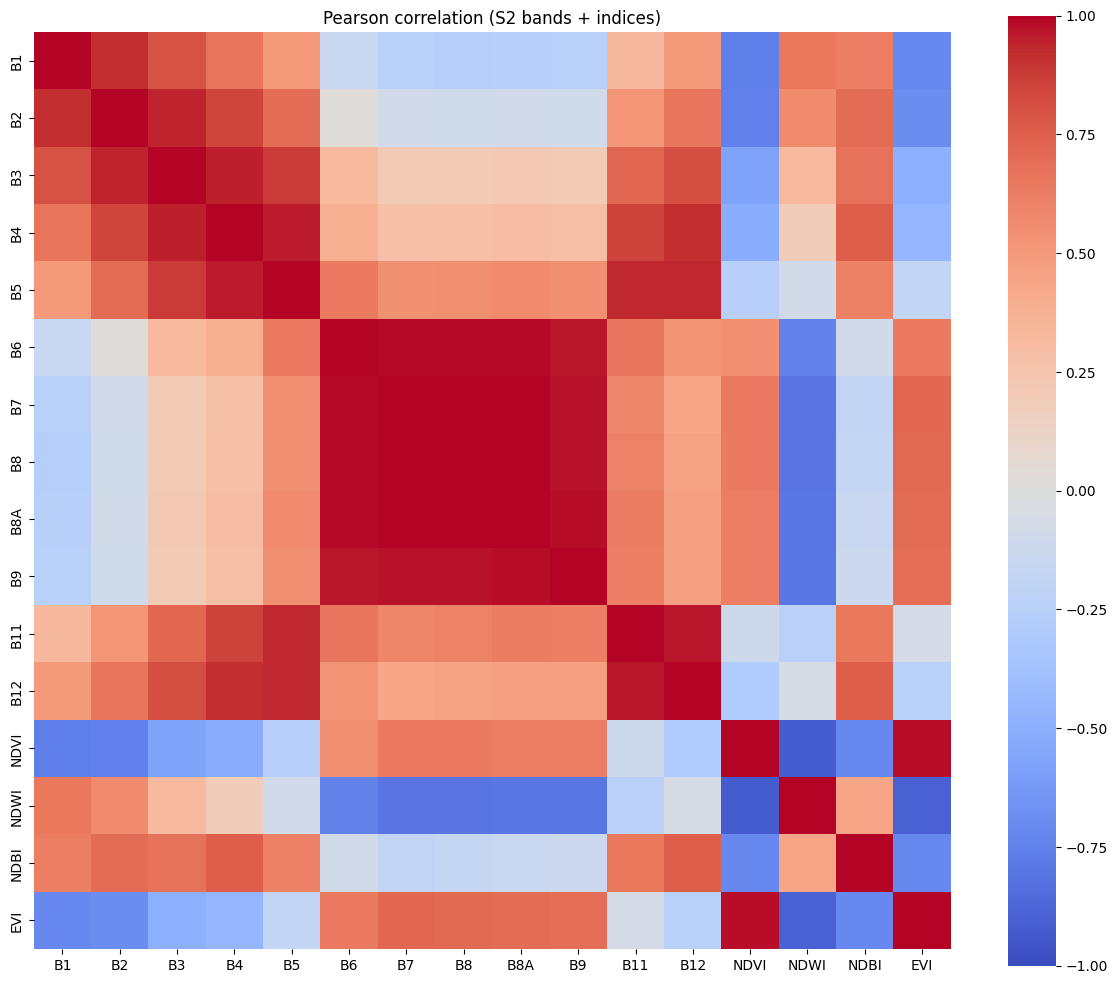

In [58]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

counties = ee.FeatureCollection("TIGER/2018/Counties")
roi_fc = (counties
          .filter(ee.Filter.eq("STATEFP", "06"))
          .filter(ee.Filter.eq("NAME", "Sonoma")))
roi = roi_fc.geometry()


m = geemap.Map()
m.centerObject(roi_fc, 9)
m.addLayer(roi_fc.style(color="00ffff", fillColor="00000000", width=2), {}, "ROI")
m


YEAR = 2021
START = f"{YEAR}-05-01"
END   = f"{YEAR}-10-01"
MAX_CLOUD = 25

def mask_s2_qa60(img: ee.Image) -> ee.Image:
    qa = img.select("QA60")
    cloud_bit = 1 << 10
    cirrus_bit = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(cirrus_bit).eq(0))
    return (img.updateMask(mask)
              .divide(10000)
              .copyProperties(img, img.propertyNames()))

s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .filterBounds(roi)
      .filterDate(START, END)
      .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", MAX_CLOUD))
      .map(mask_s2_qa60))

composite = s2.median().clip(roi)


rgb_vis = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 0.30}
m.addLayer(composite, rgb_vis, f"S2 median {YEAR} May-Sep")


def add_indices(img: ee.Image) -> ee.Image:
    ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
    ndwi = img.normalizedDifference(["B3", "B8"]).rename("NDWI")
    ndbi = img.normalizedDifference(["B11", "B8"]).rename("NDBI")
    evi = img.expression(
        "2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))",
        {"NIR": img.select("B8"), "RED": img.select("B4"), "BLUE": img.select("B2")}
    ).rename("EVI")
    return img.addBands([ndvi, ndwi, ndbi, evi])

composite_with_idx = add_indices(composite)

label = (ee.ImageCollection("ESA/WorldCover/v200")
         .first()
         .select("Map")
         .rename("label")
         .toInt()
         .clip(roi))

label = label.updateMask(label.gt(0))



s2_bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]
idx_bands = ["NDVI","NDWI","NDBI","EVI"]
cols = s2_bands + idx_bands

predictors = composite_with_idx.select(cols)
training_img = predictors.addBands(label)

N_POINTS = 200
SCALE = 60
TILESCALE = 16
SEED = 42

points_fc = ee.FeatureCollection.randomPoints(region=roi, points=N_POINTS, seed=SEED, maxError=1)

samples = (training_img.sampleRegions(
    collection=points_fc,
    properties=[],
    scale=SCALE,
    geometries=False,
    tileScale=TILESCALE
).filter(ee.Filter.notNull(["label"]))    # убрать пустые
 .filter(ee.Filter.notNull(cols))
)


# samples -> pandas.DataFrame постранично

def fc_to_df(fc, page_size=100, tries=5, sleep_s=10):
    # computeFeatures делает сетевой запрос для каждой страницы
    last = None
    for i in range(tries):
        try:
            return ee.data.computeFeatures({
                "expression": fc,
                "fileFormat": "PANDAS_DATAFRAME",
                "pageSize": page_size
            })
        except Exception as e:
            last = e
            time.sleep(sleep_s * (i + 1))
    raise last

df = fc_to_df(samples, page_size=100, tries=5, sleep_s=10)

# Чистим и оставляем только признаки
df = df[cols].apply(pd.to_numeric, errors="coerce").dropna(how="any")

print("DataFrame shape:", df.shape)
df.head()


corr = df.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", square=True)  # seaborn heatmap [web:291]
plt.title("Pearson correlation (S2 bands + indices)")
plt.tight_layout()
plt.show()

7.8. **Отбор признаков на основе корреляционного анализа.** Проанализируйте матрицу корреляции и выявите пары признаков с коэффициентом корреляции |r| > 0.85. Для каждой такой пары исключите один из признаков, руководствуясь следующими критериями:
- сохраняйте признаки с большей физической интерпретируемостью (например, NDVI предпочтительнее отдельного канала B8);
- при прочих равных сохраняйте признак с меньшим средним значением корреляции с остальными.

Сформируйте итоговый список признаков для обучения и обоснуйте исключение каждого удалённого признака в текстовой ячейке.





---

**Обоснование выбора признаков:**


На основе матрицы корреляции Пирсона для спектральных каналов Sentinel-2 и вычисленных индексов выявлены группы признаков с высокой взаимной корреляцией (|r| > 0.85), указывающие на мультиколлинеарность. Для снижения избыточности информации из набора признаков были исключены каналы B3, B7, B8, B9 и B12, а также индекс EVI, поскольку они сильно коррелируют с другими характеристиками и несут ограниченную дополнительную информацию. При отборе признаков предпочтение отдавалось физически интерпретируемым и наиболее информативным характеристикам. В итоговый набор включены спектральные каналы B2, B4, B5, B6, B8A и B11, а также индексы NDVI, NDWI и NDBI, что обеспечивает сбалансированное представление различных типов земного покрова при минимальной избыточности признаков.

---

In [ ]:
# Ваш код

7.9. Разделите данные на **обучающую (70%)** и **валидационную (30%)** выборки.


In [59]:
SEED = 42
SPLIT = 0.7

samples_rand = samples.randomColumn(columnName="rand", seed=SEED)

train_fc = samples_rand.filter(ee.Filter.lt("rand", SPLIT))
valid_fc = samples_rand.filter(ee.Filter.gte("rand", SPLIT))

print("Train size:", train_fc.size().getInfo())
print("Valid size:", valid_fc.size().getInfo())

Train size: 137
Valid size: 62


7.10. Обучите не менее **трёх классификаторов** (например, Random Forest, Gradient Boosting и SVM) на **сокращённом наборе признаков**. Для каждой модели вычислите **матрицу ошибок**, **общую точность** (Overall Accuracy) и **коэффициент Каппа**.

In [65]:
features_final = ["B2", "B4", "B5" , "B6", "B8A", "B11", "NDVI", "NDWI", "NDBI"]
LABEL = "label"
SEED = 42

def train_and_eval(name, clf):
    trained = clf.train(
        features=train_fc,
        classProperty=LABEL,
        inputProperties=features_final
    )  # обучение

    validated = valid_fc.classify(trained)  # применяем к валидации
    cm = validated.errorMatrix(LABEL, "classification")  # confusion matrix

    print(f"\n=== {name} ===")
    print("Confusion matrix:\n", cm.getInfo())
    print("Overall Accuracy:", cm.accuracy().getInfo())
    print("Kappa:", cm.kappa().getInfo())
    return trained, cm

#  Random Forest
rf = ee.Classifier.smileRandomForest(
    numberOfTrees=200,
    seed=SEED
)

#  Gradient Tree Boosting
gbt = ee.Classifier.smileGradientTreeBoost(
    numberOfTrees=200,
    shrinkage=0.1,
    samplingRate=0.7,
    seed=SEED
)

#  SVM
svm = ee.Classifier.libsvm(
    svmType="C_SVC",
    kernelType="RBF",
    cost=10
)

rf_model, rf_cm = train_and_eval("Random Forest", rf)
gbt_model, gbt_cm = train_and_eval("Gradient Tree Boost", gbt)
svm_model, svm_cm = train_and_eval("SVM (RBF)", svm)


=== Random Forest ===
Confusion matrix:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

7.11. Для сравнения обучите **один из классификаторов** (например, Random Forest) на **полном наборе признаков** (без отбора). Сравните метрики точности и сделайте вывод о влиянии отбора признаков на качество классификации.


In [66]:
LABEL = "label"
SEED = 42


features_full = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12","NDVI","NDWI","NDBI","EVI"]

# Сокращённый набор
features_sel = ["B2", "B4", "B5" , "B6", "B8A", "B11", "NDVI", "NDWI", "NDBI"]

def eval_rf(features, name):
    rf = ee.Classifier.smileRandomForest(numberOfTrees=200, seed=SEED)
    model = rf.train(train_fc, LABEL, features)
    pred = valid_fc.classify(model)
    cm = pred.errorMatrix(LABEL, "classification")
    oa = cm.accuracy()
    kappa = cm.kappa()
    print(f"\n=== RF: {name} ===")
    print("OA:", oa.getInfo())
    print("Kappa:", kappa.getInfo())
    print("Confusion matrix:\n", cm.getInfo())
    return oa, kappa, cm

oa_sel, kappa_sel, cm_sel = eval_rf(features_sel, "selected features")
oa_full, kappa_full, cm_full = eval_rf(features_full, "full features")


=== RF: selected features ===
OA: 0.7419354838709677
Kappa: 0.527393997141496
Confusion matrix:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

---




**Вывод о влиянии отбора признаков:**

По результатам классификации на валидационной выборке установлено, что использование сокращённого набора признаков приводит к более высоким значениям метрик точности. Общая точность (Overall Accuracy) для модели с отобранными признаками составила 0.742, тогда как для модели с полным набором признаков — 0.694. Аналогичная тенденция наблюдается и для коэффициента каппа: 0.527 для сокращённого набора против 0.433 для полного. Полученные результаты свидетельствуют о том, что включение избыточных и сильно коррелированных признаков негативно влияет на качество классификации, несмотря на увеличение размерности пространства признаков.

---

7.12. Визуализируйте результаты валидации: постройте **тепловые карты матриц ошибок** и **сравнительную диаграмму метрик** для всех обученных классификаторов.

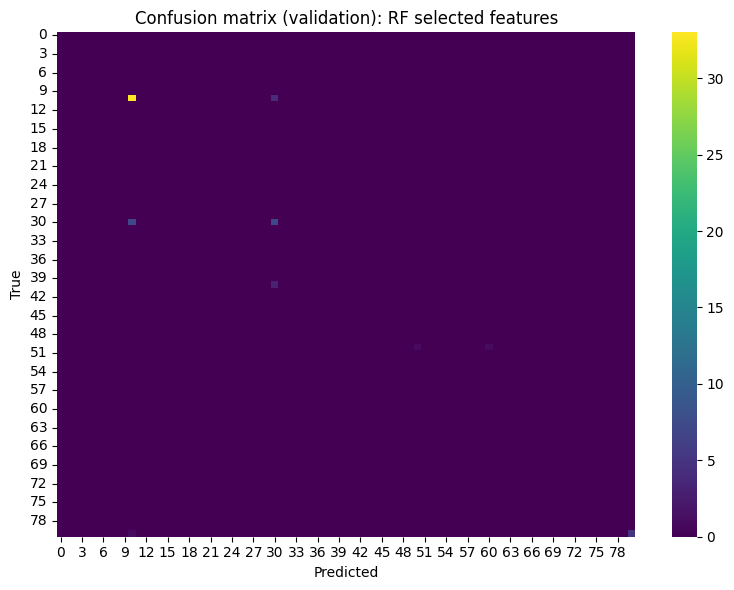

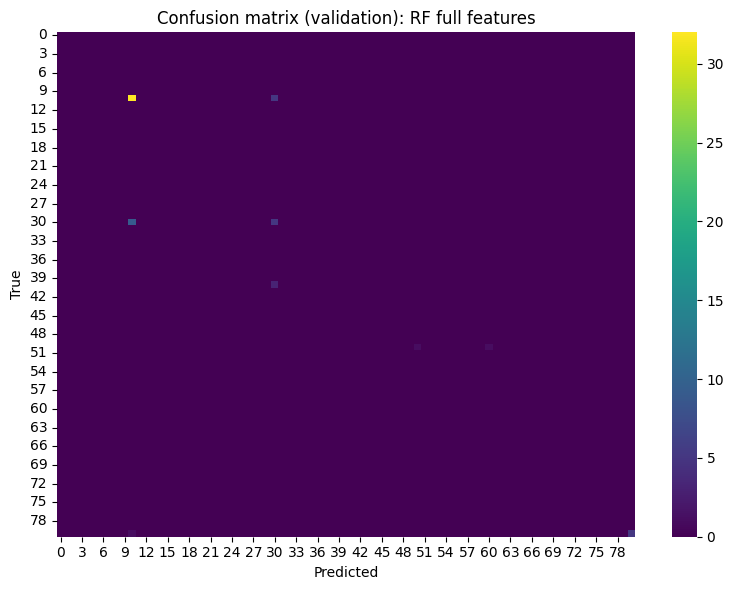

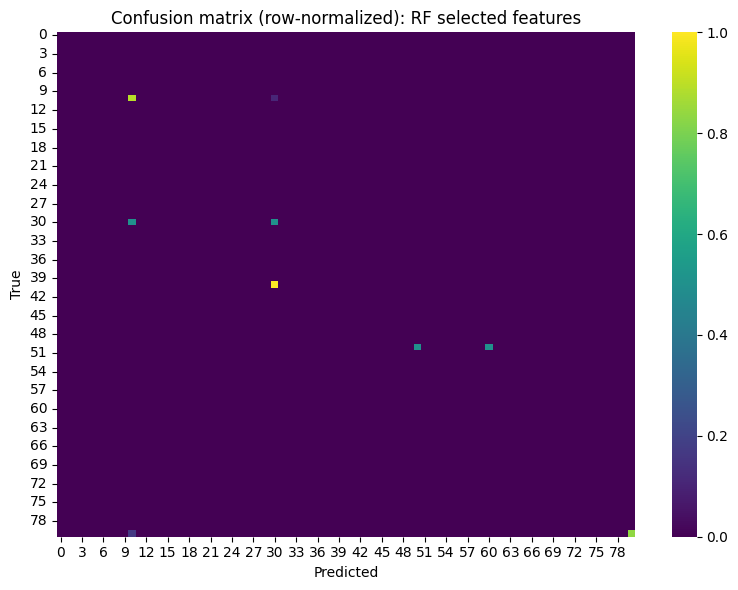

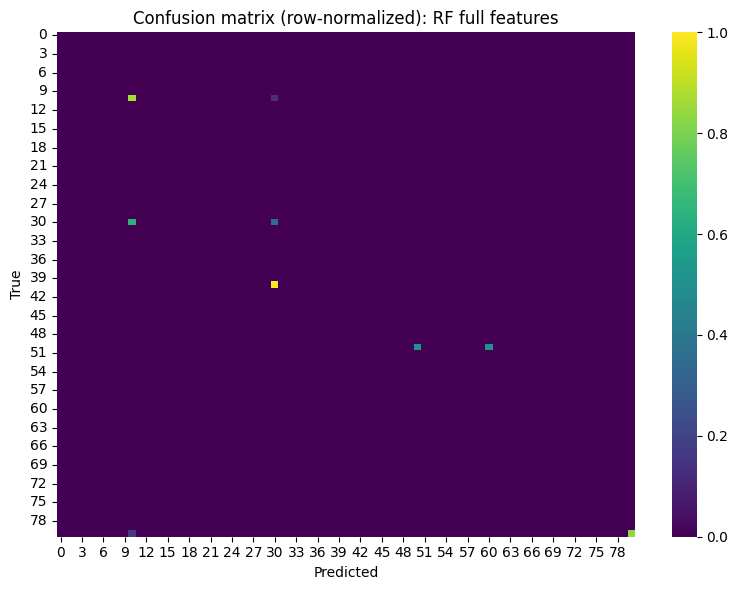

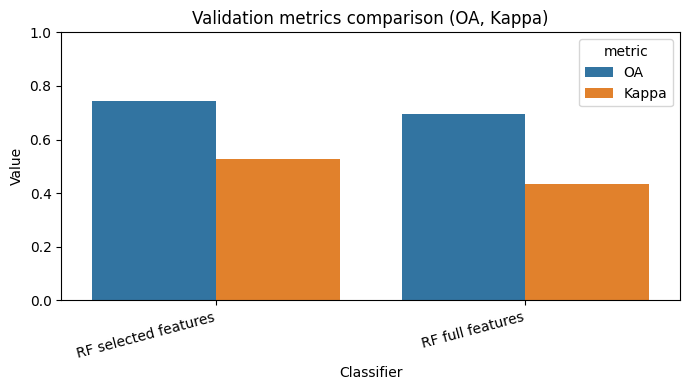

,classifier,OA,Kappa
0,RF selected features,0.741935,0.527394
1,RF full features,0.693548,0.432563


In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def cm_to_numpy(cm):
    """ee.ConfusionMatrix -> numpy array"""
    return np.array(cm.getInfo())

def num_to_float(x):
    """ee.Number -> float"""
    return float(x.getInfo())

#Confusion
cms = {
    "RF selected features": cm_to_numpy(cm_sel),
    "RF full features": cm_to_numpy(cm_full),
}

for name, cm in cms.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap="viridis", cbar=True)
    plt.title(f"Confusion matrix (validation): {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

#  Нормализация по строкам (доли внутри истинного класса)
for name, cm in cms.items():
    cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)  # защита от деления на 0
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, cmap="viridis", vmin=0, vmax=1, cbar=True)
    plt.title(f"Confusion matrix (row-normalized): {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# 3) OA / Kappa barplot
metrics_df = pd.DataFrame([
    {"classifier": "RF selected features", "OA": num_to_float(oa_sel),  "Kappa": num_to_float(kappa_sel)},
    {"classifier": "RF full features",     "OA": num_to_float(oa_full), "Kappa": num_to_float(kappa_full)},
])

metrics_long = metrics_df.melt(id_vars="classifier", var_name="metric", value_name="value")

plt.figure(figsize=(7, 4))
sns.barplot(data=metrics_long, x="classifier", y="value", hue="metric")
plt.ylim(0, 1)
plt.title("Validation metrics comparison (OA, Kappa)")
plt.xlabel("Classifier")
plt.ylabel("Value")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

metrics_df

7.13. Выберите лучшую модель по метрике Каппа и примените её для **классификации всей новой области интереса (выберите ее на карте, также, как делали это вначале)**. Отобразите результат на карте с легендой классов.

In [69]:
def addspectralindices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
    ndbi = img.normalizedDifference(['B11', 'B8']).rename('NDBI')
    evi = img.expression(
        '2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': img.select('B8'),
            'RED': img.select('B4'),
            'BLUE': img.select('B2'),
        }
    ).rename('EVI')
    return img.addBands([ndvi, ndwi, ndbi, evi])


compositewithidx = addspectralindices(composite)
print("Bands:", compositewithidx.bandNames().getInfo())



s2bands = [
    "B1","B2","B3","B4","B5","B6",
    "B7","B8","B8A","B9","B11","B12"
]


idxbands = ["NDVI", "NDWI", "NDBI", "EVI"]


predictors = compositewithidx.select(s2bands + idxbands)



if 'featuresfinal' not in globals():
    featuresfinal = ["B2", "B4", "B5", "B6", "B8", "B11", "NDVI", "NDWI", "NDBI"]

IMG_SEL_FEATURES  = predictors.select(featuresfinal)   # выбранные признаки
IMG_FULL_FEATURES = predictors                         # все признаки



trainingimg = predictors.addBands(label)



if ('trainfc' not in globals()) or ('validfc' not in globals()):
    split = 0.7
    samples_rand = samples.randomColumn('rand', 42)
    trainfc = samples_rand.filter(ee.Filter.lt('rand', split))
    validfc = samples_rand.filter(ee.Filter.gte('rand', split))


N_TREES = 200


RF_SEL_CLASSIFIER = ee.Classifier.smileRandomForest(
    numberOfTrees=N_TREES,
    seed=42
).train(
    features=trainfc,
    classProperty='label',
    inputProperties=featuresfinal
)


full_features = predictors.bandNames()  # ee.List (server-side)

RF_FULL_CLASSIFIER = ee.Classifier.smileRandomForest(
    numberOfTrees=N_TREES,
    seed=42
).train(
    features=trainfc,
    classProperty='label',
    inputProperties=full_features
)


available = [
    ("RF selected features", IMG_SEL_FEATURES is not None, RF_SEL_CLASSIFIER is not None),
    ("RF full features",     IMG_FULL_FEATURES is not None, RF_FULL_CLASSIFIER is not None),
]

for name, ok_img, ok_rf in available:
    print("available", name + ",", ok_img, ok_rf)

if (IMG_SEL_FEATURES is None) or (IMG_FULL_FEATURES is None) \
   or (RF_SEL_CLASSIFIER is None) or (RF_FULL_CLASSIFIER is None):
    raise RuntimeError("IMG or RF is None")



classified_sel  = IMG_SEL_FEATURES.classify(RF_SEL_CLASSIFIER).rename('pred')
classified_full = IMG_FULL_FEATURES.classify(RF_FULL_CLASSIFIER).rename('pred')



valid_sel  = validfc.classify(RF_SEL_CLASSIFIER).errorMatrix('label', 'classification')
valid_full = validfc.classify(RF_FULL_CLASSIFIER).errorMatrix('label', 'classification')

print("Selected OA:", valid_sel.accuracy().getInfo())
print("Selected Kappa:", valid_sel.kappa().getInfo())
print("Full OA:", valid_full.accuracy().getInfo())
print("Full Kappa:", valid_full.kappa().getInfo())



img_to_show = classified_sel

m = geemap.Map()
m.centerObject(roi, 10)

wc_classes = {
    10: ("Tree cover",        "#006400"),
    20: ("Shrubland",         "#ffbb22"),
    30: ("Grassland",         "#ffff4c"),
    40: ("Cropland",          "#f096ff"),
    50: ("Built-up",          "#fa0000"),
    60: ("Bare / sparse",     "#b4b4b4"),
    70: ("Snow and ice",      "#f0f0f0"),
    80: ("Permanent water",   "#0064c8"),
    90: ("Herbaceous wetland","#0096a0"),
    95: ("Mangroves",         "#00cf75"),
    100:("Moss and lichen",   "#fae6a0"),
}

vis = {
    "min": 10,
    "max": 100,
    "palette": [wc_classes[k][1] for k in wc_classes],
}

m.addLayer(img_to_show.clip(roi), vis, "RF classification (selected features)")
m.addLayer(ee.FeatureCollection(roi), {"color": "yellow", "fillColor": "00000000"}, "ROI")

legenddict = {wc_classes[k][0]: wc_classes[k][1] for k in wc_classes}
m.add_legend(title="ESA WorldCover classes", legend_dict=legenddict)

m


Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE', 'NDVI', 'NDWI', 'NDBI', 'EVI']
available RF selected features, True True
available RF full features, True True
Selected OA: 0.7258064516129032
Selected Kappa: 0.49229287090558765
Full OA: 0.6935483870967742
Full Kappa: 0.43256262042389215


Map(center=[38.525168484022664, -122.92168234908593], controls=(WidgetControl(options=['position', 'transparen…

7.14. **Экспортируйте результат** классификации в формате GeoTIFF с сохранением геопривязки.

In [79]:
export_img = classified_sel.clip(roi).toInt()
task = ee.batch.Export.image.toDrive(
    image=export_img,
    description="RF_landcover_classification_Sonoma",
    folder="GEE_exports",          # папка в Google Drive
    fileNamePrefix="rf_landcover_sonoma",
    region=roi,
    scale=10,                      # разрешение Sentinel-2
    crs="EPSG:4326",               # географическая проекция
    maxPixels=1e13,
    fileFormat="GeoTIFF"
)

task.start()